<a href="https://colab.research.google.com/github/ekqlsrla/TextBook/blob/main/HandsOn_MachineLearning/Chapter03_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **핸즈온 머신러닝**
---
---

# **Chapter 3 : 분류**

---
## 3.1 MNIST

In [ ]:
#MNIST 데이터셋을 내려받는 코드

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version = 1, cache=True)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X,y = mnist['data'], mnist['target']
X.shape

(70000, 784)

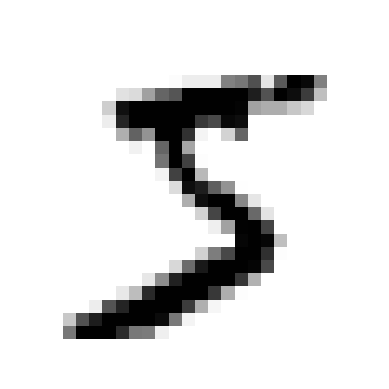

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.to_numpy()[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [ ]:
y[0]

'5'

In [ ]:
#y를 정수로 변환
import numpy as np

y = y.astype(np.uint8)

In [ ]:
#훈련세트와 테스트 세트 분리

X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

## 3.2 이진 분류기 훈련

* **이진분류기** 두 개의 클래스를 구분할 수 있는 분류기

In [ ]:
y_train_5 = (y_train== 5)
y_test_5 = (y_test == 5)

* **확률적 경사하강법(SGD)** : 매우 큰 데이터셋을 효율적으로 처리하는 장저

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state= 42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## 3.3 성능 측정

### 1) 교차 검증을 사용한 정확도 측정



#### (1) `StratifiedKFold 검증`

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42,shuffle = True)

for train_index, test_index in skfolds.split(X_train,y_train_5) :
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.loc[train_index,]
  y_train_folds = y_train_5.loc[train_index,]
  X_test_fold = X_train.loc[test_index,]
  y_test_fold = y_train_5.loc[test_index,]

  clone_clf.fit(X_train_folds,y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


#### (2) `cross_val_score()`

* 훈련 세트를 **k**개의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 푼련시킨 모델을 사용

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator) :
  def fit(self,X,y = None) :
    return self
  def predict(self,X) :
    return np.zeros((len(X),1),dtype = bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

### 2) 오차행렬

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv = 3)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
#완벽한 분류기일 경우

y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

#### (1) 정밀도

$$ 정밀도 = \frac{TP}{TP+FP}$$

* TP : 진짜 양성의 수
* FP : 거짓 양성의 수

#### (2) 재현율 : recall
-> 분류기가 정확하게 감지한 양성 샘플의 비율로, 민감도 또는 진짜 양성비율(TPR)이라고도 함

$$ 재현율 = \frac{TP}{TP+FN}$$

### 3) 정밀도와 재현율

In [ ]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5, y_train_pred) #양성이라고 판별된 수 중에서 진짜 양성의 갯수

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)
#진짜 양성 갯수 중에서 양성으로 판별된

0.6511713705958311

#### (1) F1 점수 : 정밀도와 재현율의 조화평균

$$ F_1 = \frac{2}{\frac{1}{정밀도} + \frac{1}{재현율}} = 2 \times \frac{정밀도 \times 재현율}{정밀도 + 재현율} = \frac{TP}{TP + \frac{FN + FP}{2}}$$


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 4) 정밀도/재현율 트레이드 오프

: 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지인 경우

* `decision_function()` | 예측에 사용한 각 샘플의 점수

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

* 이미지가 실제로 숫자 5이고 **임곗값이 0일 때는 분류기가 이를 감지**했지만, 임곗값을 8,000으로 높이면 이를 놓치게 됨

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred #임곗값을 높이면 재현율이 줄어든다

array([False])

* 적절한 임곗값을 구하기 위해 먼저 `cross_val_predict()`함수를 사용해 훈련 세트에 있는 모든 샘플의 점수 구함
  **예측 결과가 아니라 결정 점수를 반환하도록 지정**

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train,y_train_5, cv = 3, method = 'decision_function')

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

그림 저장: precision_recall_vs_threshold_plot


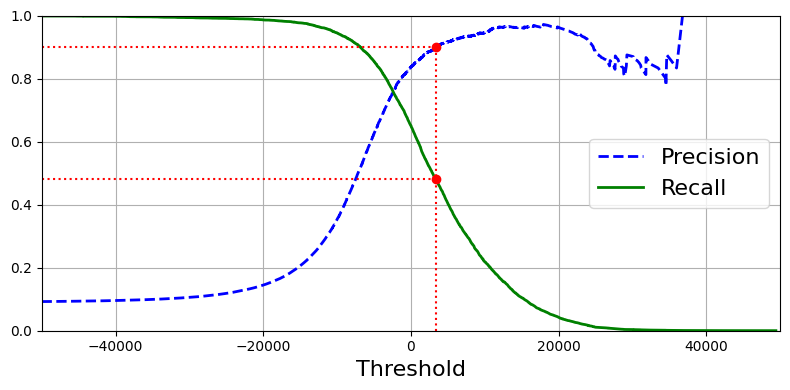

In [ ]:
# 정밀도와 재현율 그래프 그리기. x 축은 임곗값을 가리킴.
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2) # 정밀도 어레이 마지막 항목 무시
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)        # 재현율 어레이 마지막 항목 무시
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

# 정밀도 90%가 달성되는 지점에서의 재현율과 임곗값
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# 빨강 점과 빨강 점선 그리기
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")  # 수직 빨강 점선
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                 # 위 수평 빨강 점선
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")  # 아래 수평 빨강 점선
plt.plot([threshold_90_precision], [0.9], "ro")                              # 위 빨강 점
plt.plot([threshold_90_precision], [recall_90_precision], "ro")              # 아래 빨강 점

import os

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
#정밀도

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
#재현율

recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

=> **재현율이 너무 낮다면** 높은 정밀도의 분류기는 전혀 유용하지 않음

### 5) ROC 곡선

* **거짓양성비율**(FPR)에 대한 **진짜 양성비율**(TPR)의 곡선
* **FPR** : 1에서 음성으로 정학하게 분류한 음성 샘플의 비율인 **진짜 음성비율(TNR)**을 뺀 값


In [ ]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds = roc_curve(y_train_5, y_scores)

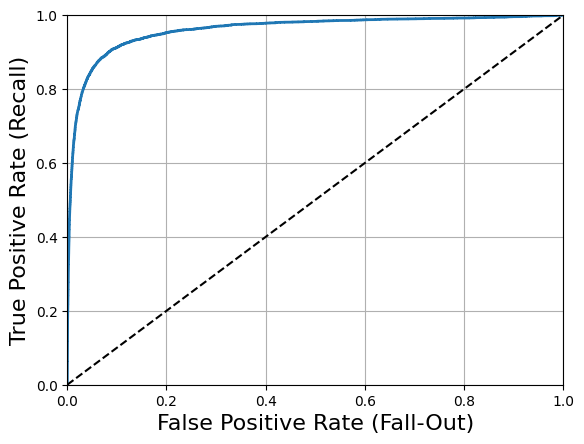

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plot_roc_curve(fpr,tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

* `RandomForestClassifier`를 훈련시켜 `SGDClassifier`의 ROC 곡선과 ROC-AUC 점수 비교

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train,y_train_5, cv = 3,
                                    method = 'predict_proba')

In [ ]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest,tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

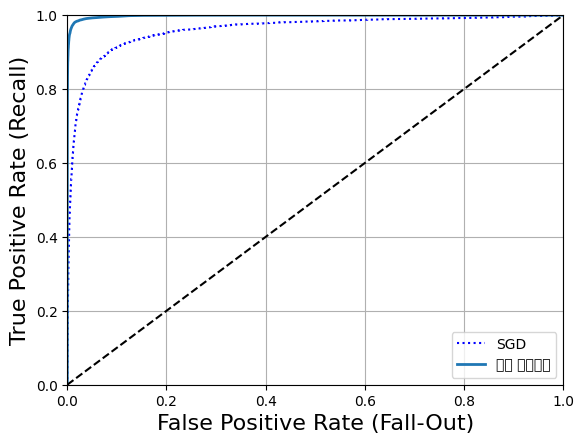

In [ ]:
plt.plot(fpr,tpr,'b:',label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest,'랜덤 포레스트')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

## 3.4 다중분류

* **OvR (one-versus-the-rest)** 전략 | 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
  * 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호하나 대부분의 이진 분류알고리즘에서는 OvR을 선호

* **OvO(one-versus-one)** 전략 | 0과 1 구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는
  * 장점 : 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요

In [ ]:
#sklearn.svm.SVC 클래스를 사용해 서포트 벡터 머신 분류기 테스트

from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

* 사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 `OneVsOneClassifier`나 `OneVsRestClassifier`를 사용

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr

10

In [ ]:
#SGDclassifier 훈련

sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
#SGDClassifier 정확도 평가

cross_val_score(sgd_clf,X_train,y_train,cv = 3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train,cv = 3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled,y_train,cv = 3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

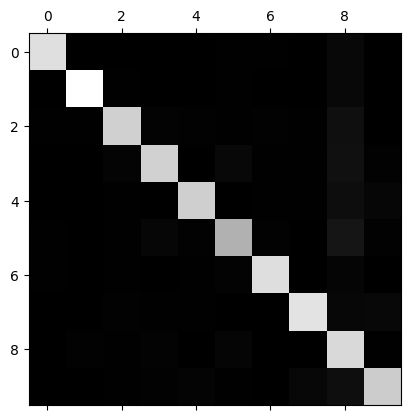

In [ ]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1,keepdims = True)
norm_conf_mx = conf_mx / row_sums

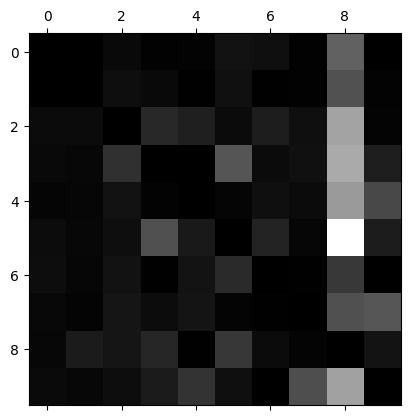

In [ ]:
#다른 항목 그대로 유지하고 주대각선만 0으로 채워서 그래프 그릭;
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

## 3.6 다중 레이블 분류

: 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [ ]:
#모든 레이블에 대한 F1점수의 평균 계산

y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

0.976410265560605

## 3.7 다중 출력 분류

In [ ]:
noise = np.random.randint(0,100,(len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)